# Hypothesis 26

### Freight value changes according to the product's weight and/or volume (height * length * width)

In [1]:
from pyspark.sql import SparkSession, functions as F, types as T
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
products_df = spark.read \
                .option('quote', '\"') \
                .option('escape', '\"') \
                .csv('./dataset/olist_products_dataset.csv', header=True, multiLine=True, inferSchema=True)

orders_df = spark.read \
                 .option('escape', '\"') \
                 .option('quote', '\"') \
                 .csv('./dataset/olist_orders_dataset.csv', header=True, multiLine=True, inferSchema=True)


order_items_df = spark.read \
                      .option('quote', '\"') \
                      .option('escape', '\"') \
                      .csv('./dataset/olist_order_items_dataset.csv', header=True, multiLine=True, inferSchema=True)

customers_df = spark.read \
                  .option('escape', '\"') \
                  .option('quote', '\"') \
                  .csv('./dataset/olist_customers_dataset.csv', header=True, multiLine=True, inferSchema=True)

sellers_df = spark.read \
                  .option('escape', '\"') \
                  .option('quote', '\"') \
                  .csv('./dataset/olist_sellers_dataset.csv', header=True, multiLine=True, inferSchema=True)

geo_df = spark.read \
                  .option('escape', '\"') \
                  .option('quote', '\"') \
                  .csv('./dataset/olist_geolocation_dataset.csv', header=True, multiLine=True, inferSchema=True)

print('Products Schema')
products_df.printSchema()

print('Order Items Schema')
order_items_df.printSchema()

df = order_items_df.join(products_df, 'product_id')

Products Schema
root
 |-- product_id: string (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- product_name_lenght: integer (nullable = true)
 |-- product_description_lenght: integer (nullable = true)
 |-- product_photos_qty: integer (nullable = true)
 |-- product_weight_g: integer (nullable = true)
 |-- product_length_cm: integer (nullable = true)
 |-- product_height_cm: integer (nullable = true)
 |-- product_width_cm: integer (nullable = true)

Order Items Schema
root
 |-- order_id: string (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)



In [4]:
volume = F.udf(lambda x, y, z: float(x) * float(y) * float(z), T.DoubleType())

In [5]:
aux_df = df.select(F.col('product_id'),
                   F.col('freight_value').alias('freight'),
                   F.col('product_weight_g').alias('weight'),
                   F.col('product_length_cm').alias('length'),
                   F.col('product_width_cm').alias('width'),
                   F.col('product_height_cm').alias('height'),
                   F.col('order_id')) \
            .filter(F.col('height').isNotNull())

aux_df = aux_df.withColumn('volume', volume('length', 'width', 'height'))

In [6]:
aux_df.show()

+--------------------+-------+------+------+-----+------+--------------------+--------+
|          product_id|freight|weight|length|width|height|            order_id|  volume|
+--------------------+-------+------+------+-----+------+--------------------+--------+
|4244733e06e7ecb49...|  13.29|   650|    28|   14|     9|00010242fe8c5a6d1...|  3528.0|
|e5f2d52b802189ee6...|  19.93| 30000|    50|   40|    30|00018f77f2f0320c5...| 60000.0|
|c777355d18b72b67a...|  17.87|  3050|    33|   33|    13|000229ec398224ef6...| 14157.0|
|7634da152a4610f15...|  12.79|   200|    16|   15|    10|00024acbcdf0a6daa...|  2400.0|
|ac6c3623068f30de0...|  18.14|  3750|    35|   30|    40|00042b26cf59d7ce6...| 42000.0|
|ef92defde845ab845...|  12.69|   450|    24|   15|     8|00048cc3ae777c65d...|  2880.0|
|8d4f2bb7e93e6710a...|  11.85|   200|    27|   20|     5|00054e8431b9d7675...|  2700.0|
|557d850972a7d6f79...|  70.75| 13805|    35|   45|    75|000576fe39319847c...|118125.0|
|310ae3c140ff94b03...|  11.65|  

In [8]:
aux_df.stat.corr('freight', 'volume')

0.5872700711964617

In [9]:
aux_df.stat.corr('freight','weight')

0.6104202350972848

In [10]:
temp_df = aux_df.limit(10).select('freight', 'weight', 'volume')
temp_df.show()

+-------+------+--------+
|freight|weight|  volume|
+-------+------+--------+
|  13.29|   650|  3528.0|
|  19.93| 30000| 60000.0|
|  17.87|  3050| 14157.0|
|  12.79|   200|  2400.0|
|  18.14|  3750| 42000.0|
|  12.69|   450|  2880.0|
|  11.85|   200|  2700.0|
|  70.75| 13805|118125.0|
|  11.65|  2000|  5760.0|
|   11.4|   850|  1827.0|
+-------+------+--------+



In [23]:
model_df = aux_df.select('weight','volume', 'freight').toPandas()
model_df.head()

,weight,volume,freight
0,650,3528.0,13.29
1,30000,60000.0,19.93
2,3050,14157.0,17.87
3,200,2400.0,12.79
4,3750,42000.0,18.14


# Multiple Linear Regression

In [37]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import pandas as pd
import numpy as np

In [30]:
x = model_df[['weight', 'volume']].values
y = model_df['freight'].values

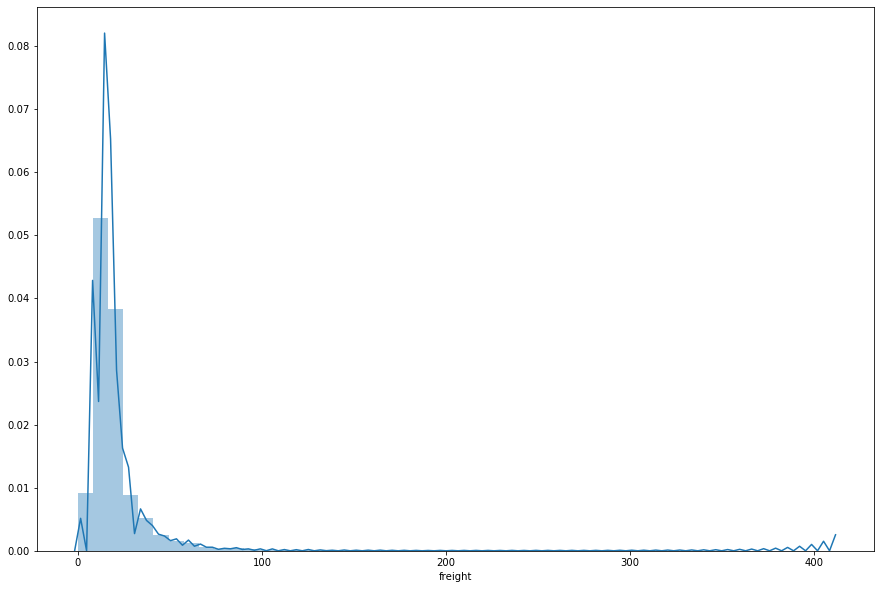

In [31]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(model_df['freight'])

In [76]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [77]:
regressor = LinearRegression()  
regressor.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [78]:
y_pred = regressor.predict(x_test)

In [86]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_reduced = df.head(15)

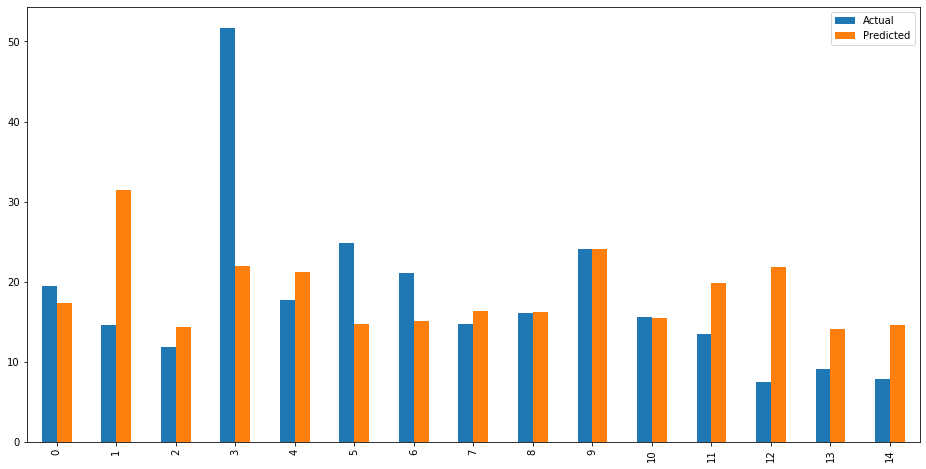

In [87]:
df_reduced.plot(kind='bar', figsize=(16,8))
plt.show()

In [81]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 6.993570584553588
Mean Squared Error: 149.27185411292032
Root Mean Squared Error: 12.21768611943032
